In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy.stats import truncnorm
import matplotlib.pylab as pylab
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb
import joblib

## Phân Tích

In [2]:
#tạo DataFrame với các cột đã được số hóa
df_raw = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/batdongsan/numerized/NhaO_numerized-dataset.csv',index_col=False)

In [3]:
rows  = df_raw[df_raw['MucGia'] < 200000000]
df_raw = df_raw.drop(index = rows.index)
rows  = df_raw[df_raw['MucGia'] > 200000000000]
df_raw = df_raw.drop(index = rows.index)

df_raw = df_raw.dropna(subset=['City', 'District', 'Ward','MucGia','SoTang','SoPhongNgu','SoToilet'])

df_raw = df_raw.drop(columns='HuongBanCong')


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   DiaChi      24205 non-null  object 
 2   City        24205 non-null  float64
 3   District    24205 non-null  float64
 4   MucGia      24205 non-null  float64
 5   Lat         23869 non-null  float64
 6   Long        23869 non-null  float64
 7   MatTien     17245 non-null  float64
 8   PhapLy      22027 non-null  float64
 9   DuongVao    15305 non-null  float64
 10  HuongNha    7950 non-null   float64
 11  SoTang      24205 non-null  float64
 12  SoPhongNgu  24205 non-null  float64
 13  SoToilet    24205 non-null  float64
 14  NoiThat     17227 non-null  float64
 15  Ward        24205 non-null  float64
dtypes: float64(15), object(1)
memory usage: 3.1+ MB


In [5]:
df_raw = df_raw.drop(columns=['Lat','Long'])

In [6]:
# Hàm để sinh giá trị ngẫu nhiên từ truncated normal distribution
def truncated_normal(mean, std, lower, upper, size):
    return truncnorm(
        (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std).rvs(size)

# Hàm để điền các giá trị bị thiếu trong một cột số
def fill_missing_with_random(column):
    if column.dtype.kind in 'biufc':  # Kiểm tra nếu cột là số
        # Tính trung bình và độ lệch chuẩn của cột (bỏ qua giá trị bị thiếu)
        mean = np.mean(column.dropna())
        std = np.std(column.dropna())
        
        # Xác định vị trí các giá trị bị thiếu
        missing_indices = np.where(column.isnull())[0]
        
        # Sinh giá trị ngẫu nhiên từ truncated normal distribution nếu là cột HuongNha
        if column.name == 'HuongNha':
            random_data = truncated_normal(mean, std, 1, 8, len(missing_indices))
        else:
            # Sinh giá trị ngẫu nhiên từ phân phối chuẩn
            random_data = np.random.normal(loc=mean, scale=std, size=len(missing_indices))
            # Đảm bảo không có giá trị âm
            random_data = np.abs(random_data)
        
        # Điền giá trị bị thiếu bằng các giá trị ngẫu nhiên đã sinh ra
        column.iloc[missing_indices] = random_data
        
    return column

# Ví dụ áp dụng hàm cho DataFrame
# Giả sử df_raw là DataFrame cần xử lý
df_raw['HuongNha'] = fill_missing_with_random(df_raw['HuongNha'])

C:\Users\quanp\AppData\Local\Temp\ipykernel_12120\2868429101.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc[missing_indices] = random_data


In [7]:
df_raw.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward
count,24205.000000,24205.000000,24205.000000,2.420500e+04,17245.000000,22027.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,17227.000000,24205.000000
mean,107.193584,42.764264,433.928445,1.665236e+10,6.506114,1.106960,11.098968,4.878822,3.897583,5.297335,5.254617,2.041389,15532.489899
std,172.320227,36.598464,344.943141,2.170678e+10,5.251218,0.542065,13.343213,1.832148,1.752670,5.997421,6.296579,0.741979,12223.951486
min,0.280000,1.000000,1.000000,3.000000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,50.000000,1.000000,8.000000,5.500000e+09,4.000000,1.000000,5.000000,3.522625,3.000000,3.000000,3.000000,2.000000,328.000000
50%,73.500000,54.000000,555.000000,9.500000e+09,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000
75%,110.000000,79.000000,766.000000,1.800000e+10,7.000000,1.000000,13.500000,6.132725,5.000000,5.000000,5.000000,2.000000,26968.000000
max,12468.000000,96.000000,964.000000,2.000000e+11,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000


In [8]:

columns_to_floor = ['HuongNha']

# Làm tròn xuống các giá trị cho các cột
for column in columns_to_floor:
    df_raw[column] = np.floor(df_raw[column])


In [9]:
df_raw.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward
count,24205.000000,24205.000000,24205.000000,2.420500e+04,17245.000000,22027.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,17227.000000,24205.000000
mean,107.193584,42.764264,433.928445,1.665236e+10,6.506114,1.106960,11.098968,4.540343,3.897583,5.297335,5.254617,2.041389,15532.489899
std,172.320227,36.598464,344.943141,2.170678e+10,5.251218,0.542065,13.343213,1.863658,1.752670,5.997421,6.296579,0.741979,12223.951486
min,0.280000,1.000000,1.000000,3.000000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,50.000000,1.000000,8.000000,5.500000e+09,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000
50%,73.500000,54.000000,555.000000,9.500000e+09,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000
75%,110.000000,79.000000,766.000000,1.800000e+10,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000
max,12468.000000,96.000000,964.000000,2.000000e+11,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000


In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   DiaChi      24205 non-null  object 
 2   City        24205 non-null  float64
 3   District    24205 non-null  float64
 4   MucGia      24205 non-null  float64
 5   MatTien     17245 non-null  float64
 6   PhapLy      22027 non-null  float64
 7   DuongVao    15305 non-null  float64
 8   HuongNha    24205 non-null  float64
 9   SoTang      24205 non-null  float64
 10  SoPhongNgu  24205 non-null  float64
 11  SoToilet    24205 non-null  float64
 12  NoiThat     17227 non-null  float64
 13  Ward        24205 non-null  float64
dtypes: float64(13), object(1)
memory usage: 2.8+ MB


In [11]:
#thêm một cột LogPrice để so sánh với các cột khác. Giúp giá trị nhỏ lại để dễ trực quan
df_raw['LogPrice'] = np.log(df_raw['MucGia'])

#thêm cột USD để về sau xây dựng mô hình với giá USD hạn chế được sai số do VND quá lớn (tỉ giá đổi 25k / 1$)
df_raw['USD']=df_raw['MucGia'].astype(float)/25000

In [12]:
# Thiết kế biểu đồ
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

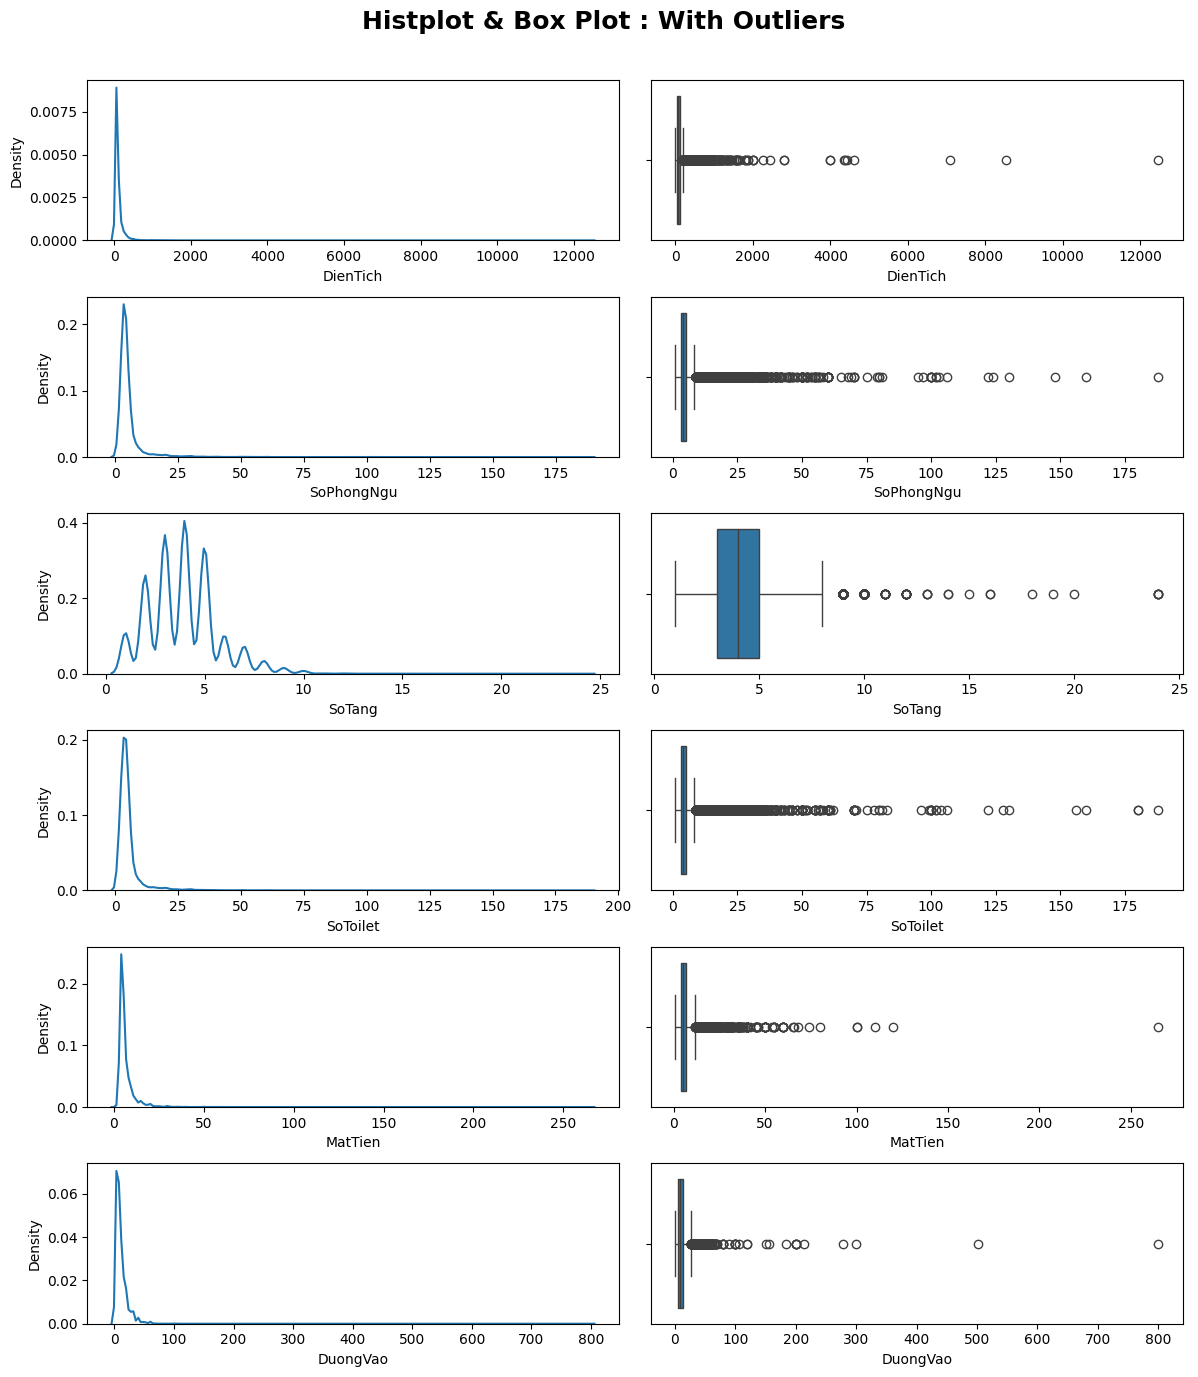

In [13]:
fig, ax = plt.subplots(6,2, figsize = (12,14))

fig.suptitle('Histplot & Box Plot : With Outliers', size = 18, fontweight="bold")
sns.kdeplot(ax= ax[0,0], data = df_raw, x = 'DienTich')
sns.boxplot(ax= ax[0,1], data = df_raw, x = 'DienTich')
sns.kdeplot(ax= ax[1,0], data = df_raw, x = 'SoPhongNgu')
sns.boxplot(ax= ax[1,1], data = df_raw, x = 'SoPhongNgu')
sns.kdeplot(ax= ax[2,0], data = df_raw, x = 'SoTang')
sns.boxplot(ax= ax[2,1], data = df_raw, x = 'SoTang')
sns.kdeplot(ax= ax[3,0], data = df_raw, x = 'SoToilet')
sns.boxplot(ax= ax[3,1], data = df_raw, x = 'SoToilet')
sns.kdeplot(ax= ax[4,0], data = df_raw, x = 'MatTien')
sns.boxplot(ax= ax[4,1], data = df_raw, x = 'MatTien')
sns.kdeplot(ax= ax[5,0], data = df_raw, x = 'DuongVao')
sns.boxplot(ax= ax[5,1], data = df_raw, x = 'DuongVao')


pylab.rcParams.update(rcParams)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

Diện Tích: tập trung nhiều trong khoảng dưới 1000 m2  
Số Phòng Ngủ: khoảng dưới 13 phòng  
Số Tầng: dưới 8 tầng  
Số Toilet: dưới 13 phòng  
Mặt Tiền: dưới 20 m  
Đường Vào: dưới 40 m  
Diện Tích, Số Phòng Ngủ, Số Toilet, Mặt Tiền, Đường Vào có nhiều giá trị lớn vượt giá trị tập trung min-max (outlier)

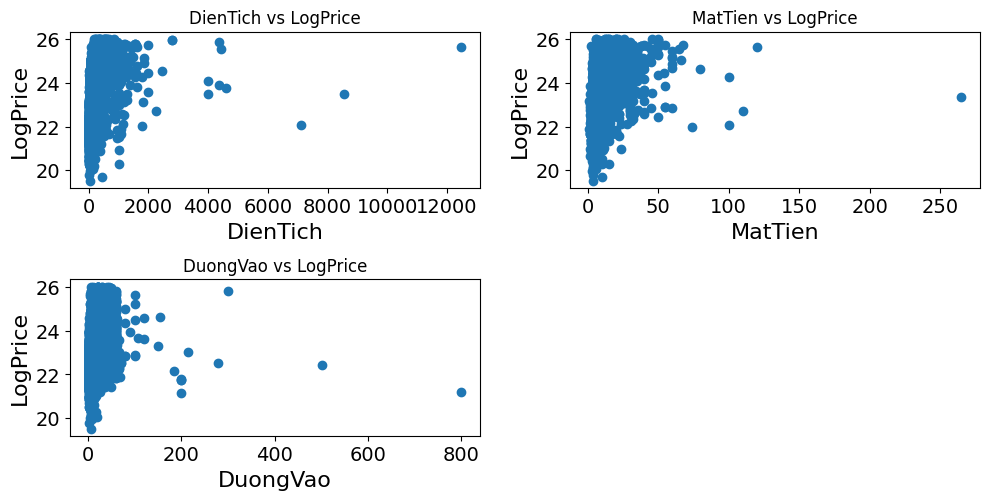

In [14]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(df_raw[x],df_raw['LogPrice'])
    plt.title(x+' vs LogPrice')
    plt.ylabel('LogPrice')
    plt.xlabel(x)


plt.figure(figsize=(10,12))


scatter('DienTich', 1)
scatter('MatTien', 2)
scatter('DuongVao', 3)
plt.tight_layout()

Diện tích, mặt tiền, đường vào có ảnh hưởng đến mức giá. vẫn có 1 vài điểm giá trị ngoại lệ có thể là giá trị rác, hoặc do ảnh hưởng bởi các nhãn khác

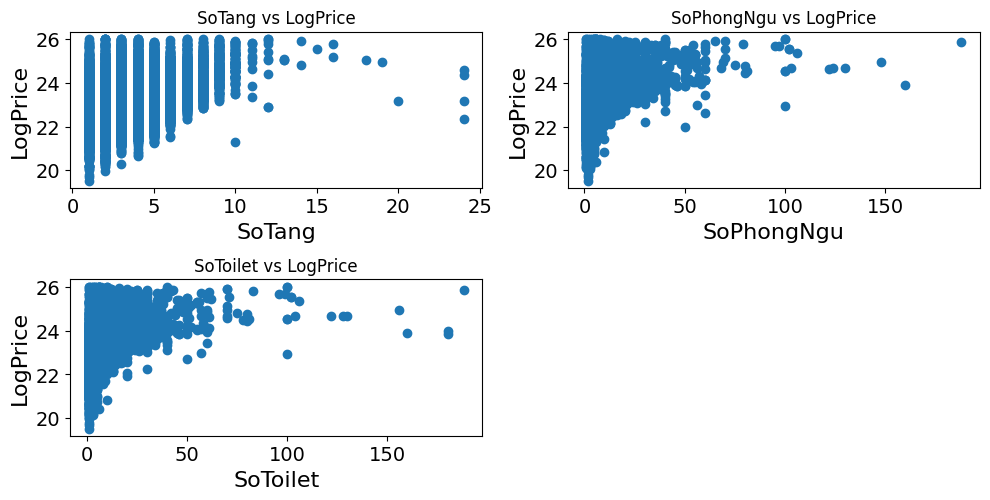

In [15]:
plt.figure(figsize=(10,12))

scatter('SoTang', 1)
scatter('SoPhongNgu', 2)
scatter('SoToilet', 3)

plt.tight_layout()

số phòng ngủ và số Toilet có ảnh hưởng đến mức giá  
số tầng không ảnh hưởng nhiều đến mức giá

C:\Users\quanp\AppData\Local\Temp\ipykernel_12120\35129562.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")


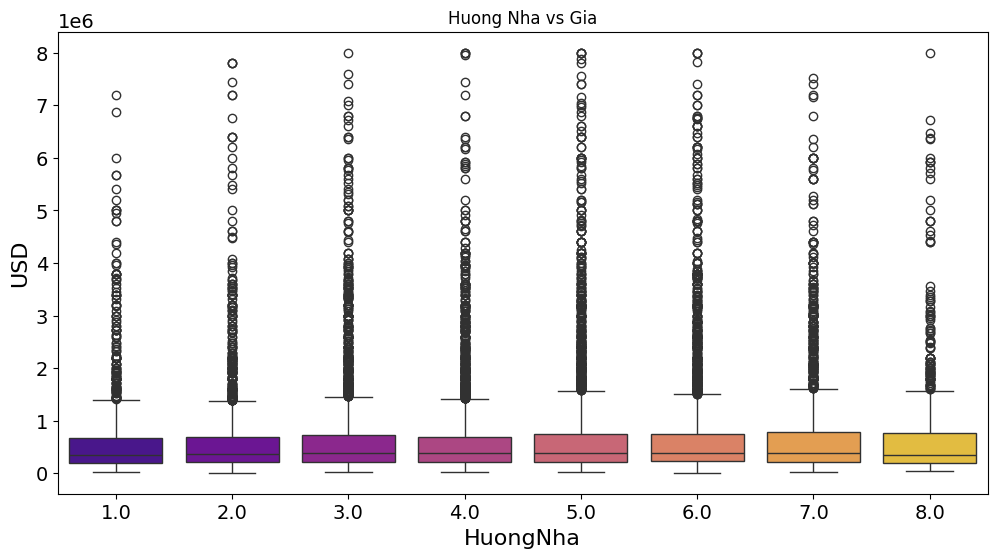

C:\Users\quanp\AppData\Local\Temp\ipykernel_12120\35129562.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")


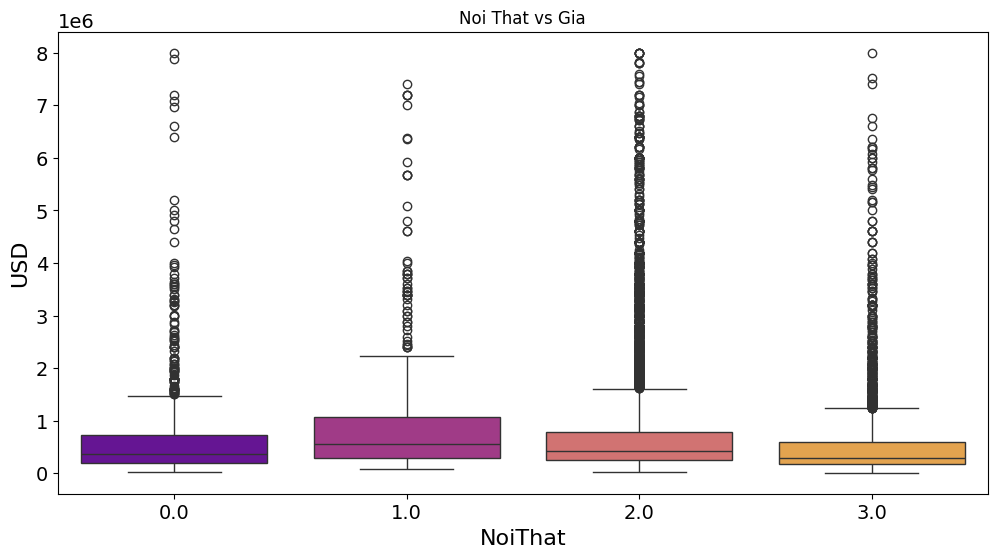

C:\Users\quanp\AppData\Local\Temp\ipykernel_12120\35129562.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")


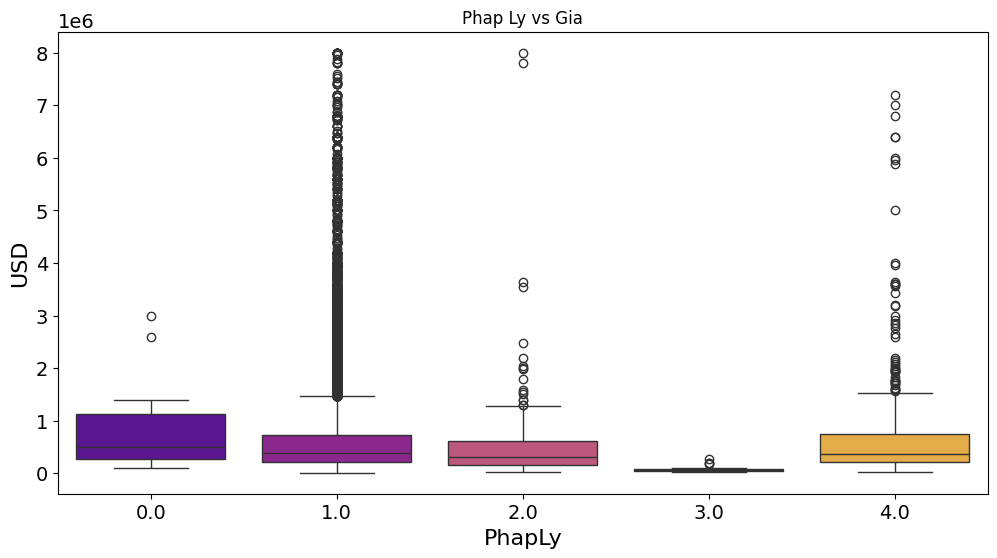

In [16]:
# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = (12, 6)

# Creating the box plots

# sns.boxplot(x=df_raw['HuongBanCong'], y=df_raw['USD'], palette="plasma")
# plt.title('Huong Ban Cong vs Gia')
# plt.show()

sns.boxplot(x=df_raw['HuongNha'], y=df_raw['USD'], palette="plasma")
plt.title('Huong Nha vs Gia')
plt.show()

sns.boxplot(x=df_raw['NoiThat'], y=df_raw['USD'], palette="plasma")
plt.title('Noi That vs Gia')
plt.show()

sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")
plt.title('Phap Ly vs Gia')
plt.show()

Nội thất, pháp lý ảnh hưởng giá  
Hướng nhà không ảnh hưởng nhiều đến giá

In [17]:
valid_cities = [
    'Hà Nội', 'Hồ Chí Minh', 'Đà Nẵng', 'Cần Thơ', 'Hải Phòng', 'Hạ Long', 'Nha Trang', 
    'Huế', 'Vũng Tàu', 'Biên Hòa', 'Quy Nhơn', 'Pleiku', 'Bình Dương', 'Bạc Liêu', 
    'Cà Mau', 'Sóc Trăng', 'Tây Ninh', 'Bến Tre', 'Long An', 'Tiền Giang', 'Trà Vinh', 
    'Hậu Giang', 'Đồng Tháp', 'An Giang', 'Kiên Giang', 'Vĩnh Long', 'Hà Tĩnh', 
    'Quảng Bình', 'Quảng Trị', 'Lâm Đồng', 'Đắk Lắk', 'Đắk Nông', 'Kon Tum', 'Gia Lai', 
    'Yên Bái', 'Thái Nguyên', 'Bắc Ninh', 'Bắc Giang', 'Hưng Yên', 'Hà Nam', 'Nam Định', 
    'Ninh Bình', 'Thanh Hóa', 'Nghệ An', 'Hòa Bình', 'Lào Cai', 'Tuyên Quang', 
    'Hà Giang', 'Cao Bằng', 'Lạng Sơn', 'Sơn La', 'Điện Biên', 'Hải Dương', 'Vĩnh Phúc', 
    'Hà Tây', 'Hưng Yên', 'Thái Bình', 'Hải Phòng', 'Bắc Kạn', 'Bắc Giang'
]

def extract_city(address):
    parts = address.split(',')
    for part in reversed(parts):
        part = part.strip().replace('.', '')
        if part in valid_cities:
            return part
    return None

# Tạo cột 'city' chứa tên thành phố
df_raw['ThanhPho'] = df_raw['DiaChi'].apply(extract_city)

df_raw.head()

,DienTich,DiaChi,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward,LogPrice,USD,ThanhPho
5,100.0,"Dự án An Phú An Khánh, Đường Nguyễn Quý Đức, P...",79.0,769.0,3.500000e+10,5.00,1.0,30.0,8.0,4.0,5.0,6.0,NaN,27091.0,24.278614,1400000.0,Hồ Chí Minh
6,39.0,"Đường Đồng Cổ, Phường Thụy Khuê, Tây Hồ, Hà Nội",1.0,3.0,6.900000e+09,4.60,1.0,2.0,3.0,5.0,3.0,4.0,2.0,112.0,22.654787,276000.0,Hà Nội
7,91.3,"Đường Võ Thị Sáu, Phường Đông Hòa, Dĩ An, Bình...",74.0,724.0,3.750000e+09,4.00,1.0,5.0,3.0,2.0,3.0,3.0,NaN,25957.0,22.045022,150000.0,Bình Dương
8,117.9,"Đường Lộ Vòng Cung, Phường An Bình, Ninh Kiều,...",92.0,916.0,6.400000e+09,6.84,1.0,20.0,6.0,1.0,2.0,1.0,2.0,31150.0,22.579564,256000.0,Cần Thơ
9,600.0,"Đường Trần Hưng Đạo, Phường Đông Hòa, Dĩ An, B...",74.0,724.0,2.500000e+10,17.00,1.0,8.0,3.0,2.0,8.0,8.0,2.0,25957.0,23.942142,1000000.0,Bình Dương


In [18]:
district = df_raw['ThanhPho'].value_counts()
district.head(50)

ThanhPho
Hà Nội         9881
Hồ Chí Minh    9824
Đà Nẵng        1088
Bình Dương      519
Nha Trang       486
Hải Phòng       401
Biên Hòa        252
Long An         196
Hưng Yên        193
Lâm Đồng        135
Bắc Ninh        127
Vũng Tàu        108
Hạ Long          88
Kiên Giang       68
Cần Thơ          54
Thanh Hóa        40
Đắk Lắk          29
Vĩnh Phúc        26
Nghệ An          23
Hà Nam           22
Quy Nhơn         17
Lào Cai          16
Hòa Bình         14
Huế              12
Nam Định         12
Tây Ninh         11
Hải Dương        10
An Giang         10
Tiền Giang        9
Thái Nguyên       8
Bắc Giang         6
Thái Bình         6
Ninh Bình         6
Hà Tĩnh           5
Bến Tre           3
Gia Lai           3
Đồng Tháp         3
Lạng Sơn          2
Yên Bái           2
Cao Bằng          2
Quảng Trị         1
Vĩnh Long         1
Quảng Bình        1
Đắk Nông          1
Kon Tum           1
Trà Vinh          1
Bạc Liêu          1
Cà Mau            1
Hà Giang          1
Sơn La     

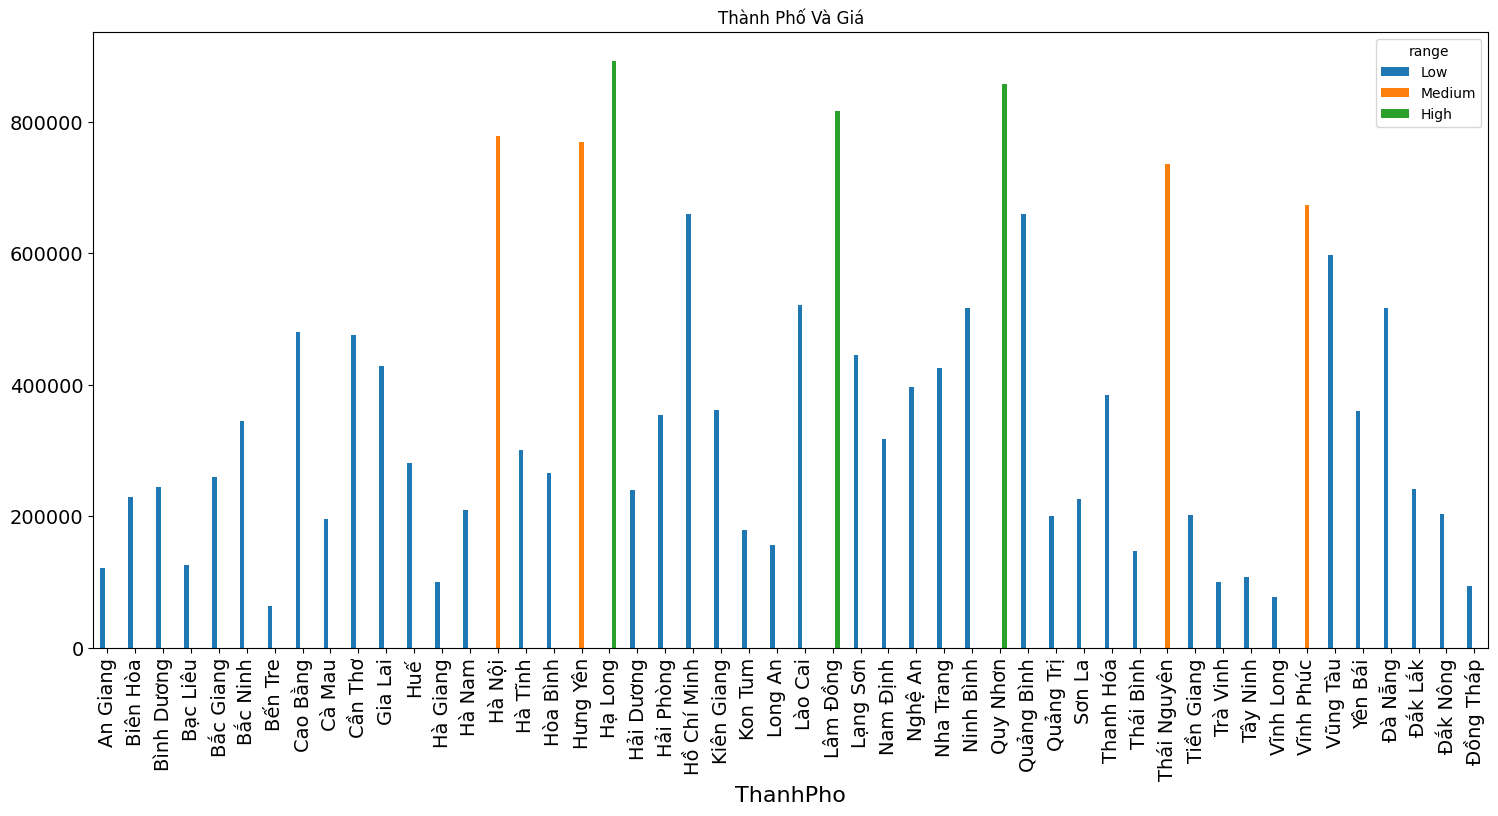

In [19]:
frame1 = df_raw

table = frame1.groupby(['ThanhPho'])['USD'].mean().reset_index()
# Gộp bảng tính giá trị trung bình vào 'frame1'
frame1 = frame1.merge(table, how='left', on='ThanhPho', suffixes=('', '_mean'))

# Chỉ định nhãn cho 3 nhóm 'Low', 'Medium', 'High'
labels = ['Low', 'Medium', 'High']

# Tạo các nhóm giá trị USD với qcut
num_bins = 3  # Số lượng nhóm bạn muốn chia
frame1['range'] = pd.qcut(frame1['USD_mean'], q=num_bins, labels=labels, duplicates='drop')

# Thiết lập kích thước hình vẽ
plt.rcParams['figure.figsize'] = (18, 8)

# Tạo DataFrame để vẽ biểu đồ
df_plot = frame1.groupby(['ThanhPho', 'range'], observed=False)['USD'].mean().unstack(fill_value=0)
df_plot.plot(kind='bar')

# Thiết lập tiêu đề cho biểu đồ
plt.title('Thành Phố Và Giá')
plt.show()

Các thành phố ở Việt Nam có ảnh hưởng lớn đến mức giá

In [39]:
# Lấy giá trị USD cao nhất
max_usd_row = df_raw.loc[df_raw['USD'].idxmax(), ['USD', 'City']]

# Lấy giá trị USD thấp nhất
min_usd_row = df_raw.loc[df_raw['USD'].idxmin(), ['USD', 'City']]

# In ra giá trị
print("Giá trị USD cao nhất:")
print(max_usd_row)

print("\nGiá trị USD thấp nhất:")
print(min_usd_row)

Giá trị USD cao nhất:
USD     8000000.0
City         79.0
Name: 2329, dtype: float64

Giá trị USD thấp nhất:
USD     12000.0
City       80.0
Name: 7692, dtype: float64


Bộ dữ thu được ta thấy  
thành Phố HCM có mức giá cao nhất: 8 000 000$ sấp xỉ 200 tỷ VND  
tỉnh Long An có mức giá thấp nhất: 12 000$ sấp xỉ 300 triệu VND  
với 25 000 = 1$

In [20]:
df_raw = df_raw.drop(columns=['ThanhPho','DiaChi'])

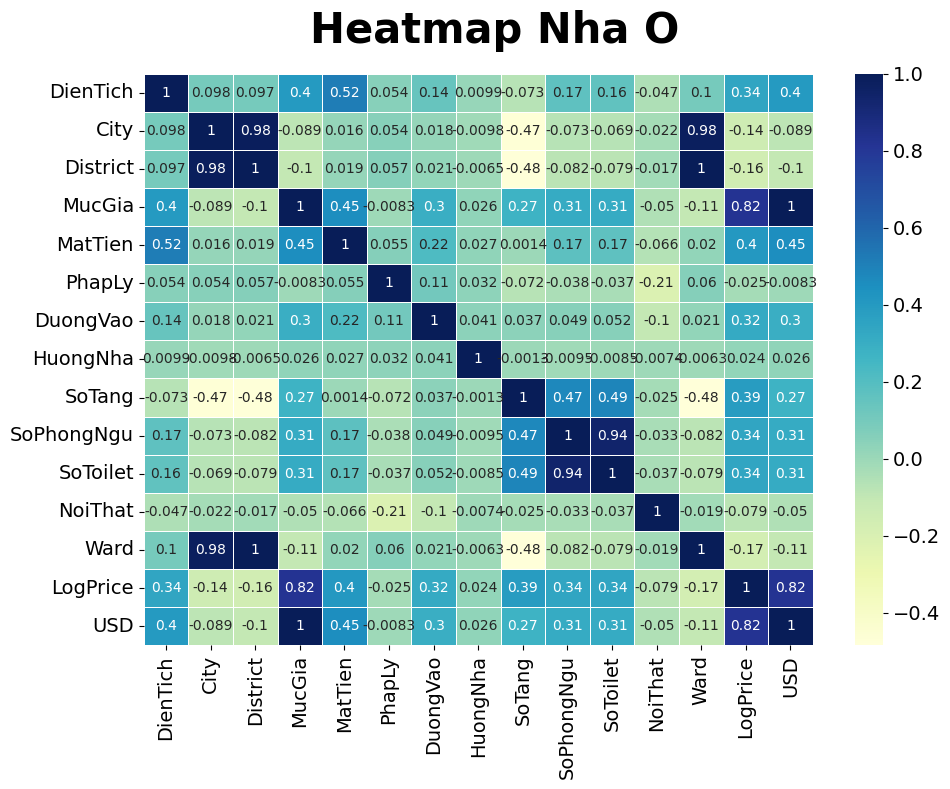

In [22]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_raw.corr(), annot = True, cmap='YlGnBu', linewidth=.5)
fig.suptitle('Heatmap Nha O',fontsize=30, fontweight="bold")
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

ta thấy Thành Phố, Huyện, Đường có mối liên kết mạnh với nhau  
Số Phòng Ngủ, Số Toilet có mối liên kết mạnh với nhau  
mấy thằng còn lại nó có mối liên kết yếu và độc lập với nhau

In [23]:
df_raw.isna().sum()

DienTich         0
City             0
District         0
MucGia           0
MatTien       6960
PhapLy        2178
DuongVao      8900
HuongNha         0
SoTang           0
SoPhongNgu       0
SoToilet         0
NoiThat       6978
Ward             0
LogPrice         0
USD              0
dtype: int64

In [24]:
df_dropped_2 = df_raw

## Xây Dựng Mô Hình

In [25]:
df_dropped_2.describe()

,DienTich,City,District,MucGia,MatTien,PhapLy,DuongVao,HuongNha,SoTang,SoPhongNgu,SoToilet,NoiThat,Ward,LogPrice,USD
count,24205.000000,24205.000000,24205.000000,2.420500e+04,17245.000000,22027.000000,15305.000000,24205.000000,24205.000000,24205.000000,24205.000000,17227.000000,24205.000000,24205.000000,2.420500e+04
mean,107.193584,42.764264,433.928445,1.665236e+10,6.506114,1.106960,11.098968,4.540343,3.897583,5.297335,5.254617,2.041389,15532.489899,23.062249,6.660946e+05
std,172.320227,36.598464,344.943141,2.170678e+10,5.251218,0.542065,13.343213,1.863658,1.752670,5.997421,6.296579,0.741979,12223.951486,0.921621,8.682711e+05
min,0.280000,1.000000,1.000000,3.000000e+08,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,19.519293,1.200000e+04
25%,50.000000,1.000000,8.000000,5.500000e+09,4.000000,1.000000,5.000000,3.000000,3.000000,3.000000,3.000000,2.000000,328.000000,22.428014,2.200000e+05
50%,73.500000,54.000000,555.000000,9.500000e+09,5.000000,1.000000,8.000000,5.000000,4.000000,4.000000,4.000000,2.000000,22045.000000,22.974558,3.800000e+05
75%,110.000000,79.000000,766.000000,1.800000e+10,7.000000,1.000000,13.500000,6.000000,5.000000,5.000000,5.000000,2.000000,26968.000000,23.613638,7.200000e+05
max,12468.000000,96.000000,964.000000,2.000000e+11,265.000000,4.000000,800.000000,8.000000,24.000000,188.000000,188.000000,3.000000,31999.000000,26.021583,8.000000e+06


In [26]:
df_dropped_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 5 to 45922
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DienTich    24205 non-null  float64
 1   City        24205 non-null  float64
 2   District    24205 non-null  float64
 3   MucGia      24205 non-null  float64
 4   MatTien     17245 non-null  float64
 5   PhapLy      22027 non-null  float64
 6   DuongVao    15305 non-null  float64
 7   HuongNha    24205 non-null  float64
 8   SoTang      24205 non-null  float64
 9   SoPhongNgu  24205 non-null  float64
 10  SoToilet    24205 non-null  float64
 11  NoiThat     17227 non-null  float64
 12  Ward        24205 non-null  float64
 13  LogPrice    24205 non-null  float64
 14  USD         24205 non-null  float64
dtypes: float64(15)
memory usage: 3.0 MB


In [27]:
X = df_dropped_2.drop(['MucGia','LogPrice','USD'], axis=1)
y = df_dropped_2['USD']

In [28]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Lưu scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Random Forest

In [31]:
# Khởi tạo và huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 398316.972536616
R² Score: 0.8064853138347605


In [33]:
# Grid Search cho tối ưu hóa siêu tham số của RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearch
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán với mô hình tốt nhất
y_pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE cho mô hình RandomForest: {rmse_rf}')
print(f'R² score cho mô hình RandomForest: {r2_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
RMSE cho mô hình RandomForest: 396158.897257282
R² score cho mô hình RandomForest: 0.8085765525302082


## XGBoost

In [34]:
# Tạo và huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost - R² Score: {r2_xgb}')

XGBoost - Root Mean Squared Error: 388753.6728226823
XGBoost - R² Score: 0.815666055926844


## LightGBM

In [35]:
# Tạo và huấn luyện mô hình LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - Root Mean Squared Error: {rmse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
LightGBM - Root Mean Squared Error: 385295.33284693677
LightGBM - R² Score: 0.8189311255552011


## kết hợp 3 thuật toán RR, GBR, LightGBM

In [36]:
#kết hợp 3 thuật toán RandomForestRegressor,GradientBoostingRegressor,LGBMRegressor để dự đoán
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xg', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Tạo và huấn luyện mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Stacking Regressor - Root Mean Squared Error: {rmse_stacking}')
print(f'Stacking Regressor - R² Score: {r2_stacking}')

# Lưu mô hình
joblib.dump(stacking_model, 'stacking_model.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 19364, number of used features: 12
[LightGBM] [Info] Start training from score 661115.079205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 15491, number of used features: 12
[LightGBM] [Info] Start training from score 656945.424551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

['stacking_model.pkl']